In [10]:
from shapely.geometry import Polygon  
from shapely import affinity    
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from utils import SensorCamera, CoverageNode, Tree
from utils import lawmowerPath
import random

random.seed(42)  # For reproducibility

DJImini3Camera = SensorCamera()
desirableGSD = 1*0.43 #cm/px
altitude = DJImini3Camera.h_desirable(desirableGSD)/100
width,height = DJImini3Camera.l(altitude) # dimensão horizontal do sensor para a altitude desejada
L = 6
poly = Polygon([(-L*height, -L*width), (L*height, -L*width), (L*height, L*width), (-L*height, L*width)])
angle_deg = 0  # ângulo da varredura em graus (0 = horizontal, 90 = vertical)
waypointsLawMower = lawmowerPath(poly, height, width, angle_deg)

areas_de_interesse = []
base = Polygon([(-0.1*height*L, -0.1*width*L), (0.1*height*L,-0.1*width*L), (0.1*height*L,0.1*width*L), (-0.1*height*L,0.1*width*L)])

p = 50 # proporção de área de interesse em relação à área total
c = 10 # número de patches de interesse
base = affinity.scale(base,np.sqrt(p/c), np.sqrt(p/c), origin=(0, 0))
cont = 0
while len(areas_de_interesse) < c:
    cont += 1
    if cont > 1000:
        cont = 0
        areas_de_interesse = []
    i = random.uniform(-1 + np.sqrt(p/c)*0.1, 1 - np.sqrt(p/c)*0.1)
    j = random.uniform(-1 + np.sqrt(p/c)*0.1, 1 - np.sqrt(p/c)*0.1)     
    poly_rand = affinity.translate(base, i*L*height, j*L*width)
    if(not any(p.intersects(poly_rand) for p in areas_de_interesse)):
        areas_de_interesse.append(poly_rand)
              
interesting_area = 0
for area in areas_de_interesse:
    interesting_area += poly.intersection(base).area
interesting_area = interesting_area /poly.area
print("p =", np.round(interesting_area * 100,2), "%", "interesting")
print("C =", len(areas_de_interesse), "patches")


p = 50.0 % interesting
C = 10 patches


In [11]:
from utils import Shortcut

altitude2 = DJImini3Camera.h_desirable(4*desirableGSD)/100
width2,height2 = DJImini3Camera.l(altitude2) # dimensão horizontal do sensor para a altitude desejada
waypointsInitial = lawmowerPath(poly, height2, width2, angle_deg)

LawnmowerTree = Tree(sensorCamera=DJImini3Camera)
BFTree = Tree(sensorCamera=DJImini3Camera)
DFTree = Tree(sensorCamera=DJImini3Camera)
ShortTree = Shortcut(DJImini3Camera,areas_de_interesse)

LawnmowerTree.add_fistLevel_nodes(waypointsLawMower, altitude,width,height)
BFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
DFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
ShortTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)

In [12]:
import itertools

def distancia(a, b):
    return np.hypot(a.x - b.x, a.y - b.y)

def ordem_otima_dos_filhos(pai, filhos, proximo_pai):
    melhor_ordem = None
    menor_distancia = float('inf')

    for perm in itertools.permutations(filhos):
        # Distância de pai → primeiro filho
        dist = distancia(pai, perm[0])
        # Distâncias entre filhos
        for i in range(len(perm)-1):
            dist += distancia(perm[i], perm[i+1])
        # Último filho → proximo_pai
        if(proximo_pai):
            dist += distancia(perm[-1], proximo_pai)

        if dist < menor_distancia:
            menor_distancia = dist
            melhor_ordem = perm

    return list(melhor_ordem)


def DeepFirst(node, areas_de_interesse, camera, min_area, nextNode = None):
    if any(p.intersection(node.polygon).area / p.area >= min_area for p in areas_de_interesse):
        candidatos = node.found_children_grid(camera)
        filhos = []
        for filho in candidatos:
            if(filho.check_interesse(areas_de_interesse,min_area)):
                filhos.append(filho)
        if filhos:
            filhos = ordem_otima_dos_filhos(node,filhos,nextNode)
        for i, filho in enumerate(filhos):
            node.add_children(filho)
            if(node.level < 1):
                if(i < len(filhos) - 1):
                    DeepFirst(filho, areas_de_interesse, camera, min_area, filhos[i+1])
                else:
                    DeepFirst(filho, areas_de_interesse, camera,min_area, nextNode)


In [13]:
min_area = 0.01
for i, node in enumerate(DFTree.nodes):
    if(i < len(DFTree.nodes) -1):
        DeepFirst(node,areas_de_interesse, DJImini3Camera,min_area,DFTree.nodes[i+1])
    else:
        DeepFirst(node,areas_de_interesse, DJImini3Camera,min_area,None)




In [14]:
from matplotlib.colors import LinearSegmentedColormap
cmap_custom = LinearSegmentedColormap.from_list(
    "azul_verde_vermelho",
    [(0.0, "blue"), (0.5, "green"), (1.0, "red")]
)

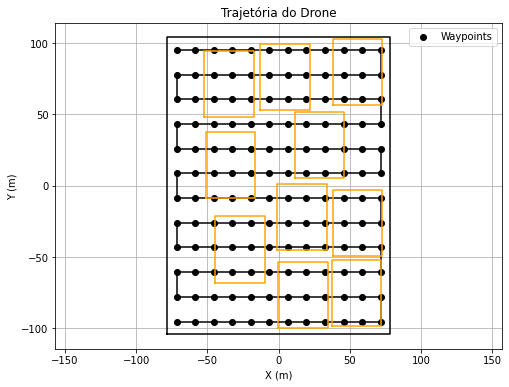

Coverage Path length (LawMower):  1.907136000000005  km


In [15]:
waypoints = np.array(waypointsLawMower)
fig, ax = plt.subplots(figsize=(8, 6))
waypoints_x = [wp[0] for wp in waypoints]
waypoints_y = [wp[1] for wp in waypoints]
ax.scatter(waypoints_x, waypoints_y, color='black', label='Waypoints', marker='o')
ax.plot(waypoints_x, waypoints_y, color='black')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black')
for area in areas_de_interesse:
    x, y = area.exterior.xy
    ax.plot(x, y, color='Orange')
plt.title('Trajetória do Drone')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()
path_length = 0
for i in range(np.size(waypoints,0)-1):
    path_length += np.linalg.norm(waypoints[i+1] - waypoints[i])
print("Coverage Path length (LawMower): ", path_length/1000, " km")

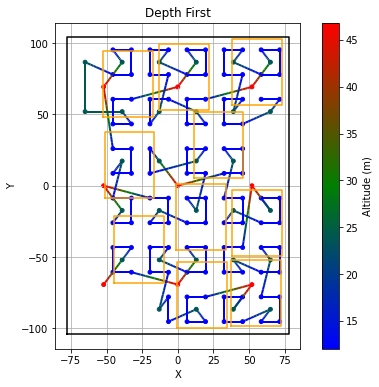

Coverage Path length (Depth First):  2.84303842799655  km


In [16]:
waypointsDF = []
for node in DFTree.nodes:
    waypointsDF.append([node.x, node.y, node.Altitude])
    for child in node.children:
        waypointsDF.append([child.x, child.y, child.Altitude])
        for child2 in child.children:
            waypointsDF.append([child2.x, child2.y, child2.Altitude])
waypointsDF = np.array(waypointsDF)

# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsDF) - 1):
    segment = interp_segment(waypointsDF[i], waypointsDF[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsDF[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsDF[:, 0], waypointsDF[:, 1], c=waypointsDF[:,2], cmap=cmap_custom, s=15)
#ax.plot(waypointsDF[:, 0], waypointsDF[:, 1], 'o', color='black', markersize=5)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Depth First")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length = 0
for i in range(np.size(waypointsDF,0)-1):
    path_length += np.linalg.norm(waypointsDF[i+1] - waypointsDF[i])
print("Coverage Path length (Depth First): ", path_length/1000, " km")

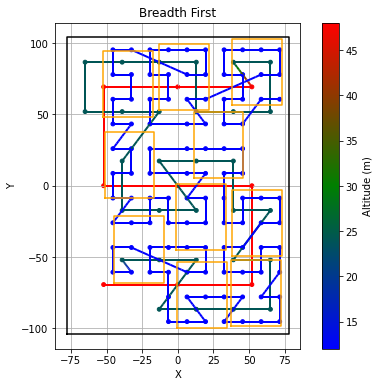

Coverage Path length (Breadth First):  3.0676388759629662  km


In [17]:
from itertools import chain

waypointsBF = []
horizonte = 5
# Nível 0 (raiz)
for node in DFTree.nodes:
    waypointsBF.append([node.x, node.y, node.Altitude])

# Nível 1 - um por vez, sempre escolhendo o melhor entre 5 candidatos
todos_filhos_n1 = list(chain.from_iterable(reversed(node.children) for node in reversed(DFTree.nodes)))
filhos_restantes = todos_filhos_n1.copy()
atual = DFTree.nodes[-1]  # começa com o u nó raiz como ponto anterior

while filhos_restantes:
    janela = filhos_restantes[:horizonte]
    proximo = filhos_restantes[horizonte] if len(filhos_restantes) > horizonte else None

    otima_ordem = ordem_otima_dos_filhos(atual, janela, proximo)

    escolhido = otima_ordem[0]
    waypointsBF.append([escolhido.x, escolhido.y, escolhido.Altitude])
    filhos_restantes.remove(escolhido)
    atual = escolhido

# Nível 2 - mesma lógica recursiva
todos_filhos_n2 = list(chain.from_iterable(child.children for node in DFTree.nodes for child in node.children))
filhos_n2 = todos_filhos_n2.copy()
while filhos_n2:
    janela = filhos_n2[:horizonte]
    proximo = filhos_n2[horizonte] if len(filhos_n2) > horizonte else None

    otima_ordem = ordem_otima_dos_filhos(atual, janela, proximo)

    escolhido = otima_ordem[0]
    waypointsBF.append([escolhido.x, escolhido.y, escolhido.Altitude])
    filhos_n2.remove(escolhido)
    atual = escolhido




waypointsBF = np.array(waypointsBF)

# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsBF) - 1):
    segment = interp_segment(waypointsBF[i], waypointsBF[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsBF[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsBF[:, 0], waypointsBF[:, 1], c=waypointsBF[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Breadth First")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length = 0
for i in range(np.size(waypointsBF,0)-1):
    path_length += np.linalg.norm(waypointsBF[i+1] - waypointsBF[i])
print("Coverage Path length (Breadth First): ", path_length/1000, " km")

Tamando do queue:  9
last_node.level == 0
Tamando do queue:  8
last_node.level == 2
Tamando do queue:  7
last_node.level == 2
Tamando do queue:  6
last_node.level == 2
Tamando do queue:  5
last_node.level == 2
Tamando do queue:  4
last_node.level == 2
Tamando do queue:  3
last_node.level == 1
Tamando do queue:  2
last_node.level == 2
Tamando do queue:  1
last_node.level == 2


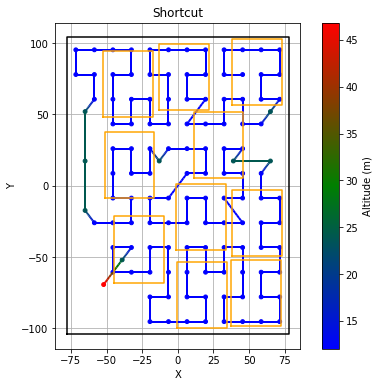

Coverage Path length (Shortcut):  1.9593722300470444  km


In [18]:
waypointsSH = []
for i,waypoint in enumerate(ShortTree):
    waypointsSH.append([waypoint.x,waypoint.y,waypoint.Altitude])
    if(i == 91):
        pass

waypointsSC = np.array(waypointsSH)
# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsSC) - 1):
    segment = interp_segment(waypointsSC[i], waypointsSC[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsSC[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsSC[:, 0], waypointsSC[:, 1], c=waypointsSC[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Shortcut")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length = 0
for i in range(np.size(waypointsSC,0)-1):
    path_length += np.linalg.norm(waypointsSC[i+1] - waypointsSC[i])
print("Coverage Path length (Shortcut): ", path_length/1000, " km")